## Baseline model

Naive approach: taking the Lag 7 feature as the prediction.\
Lag 7 feature represent the target value one week earlier.

In [25]:
import pandas as pd
import time
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from statsmodels.tsa.stattools import acf

In [26]:
def rmse(y_pred, y_true):
    MSE = mean_squared_error(y_true, y_pred)
    return math.sqrt(MSE)

def plot_series(df, title):
    plt.figure(figsize=(17, 2))
    plt.plot(df)    
    plt.xticks(rotation=45)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(16, 2))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.title('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()

def timeseries_train_test_split(X, y, test_size=0.1):
    """
        Perform train-test split with respect to time series structure
    """
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def add_lag_features(df, variable_name: str):
    df_bis = df.copy()

    lag_feat_name = 'Lag_7_' + variable_name[0]
    df_bis[lag_feat_name] = df_bis[variable_name].shift(7*24)
    # # Selecting features
    # df_bis = df_bis[features_tot + [lag_feat_name] + variables]
    # Drop missing values
    df_bis.dropna(inplace=True)
    # Reset index
    df_bis = df_bis.reset_index(drop=True)
    return df_bis, lag_feat_name

In [27]:
features_tot = [
    'Jour férié',
    'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
    'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
    'totalSnow_cm',
    'uvIndex',
    'tempC',
    'windspeedKmph',
    'precipMM',
    'humidity',
    'cloudcover',
    'is_day',
    'paris_repsire',
    'perturbation_travaux',
    'Prix du carburant'
]
features_tot_deb = features_tot + ['Lag_7_D']
features_tot_taux = features_tot + ['Lag_7_T']

variables = ['Débit horaire', "Taux d'occupation"]

### Entire Dataframe

In [28]:
whole_df = pd.read_csv("/Users/cha/Desktop/Code/eCSpress/data/final_data.csv", sep=";")
# Drop useless column
whole_df.drop('Unnamed: 0', inplace=True, axis=1)
# Dates
whole_df['Date et heure de comptage'] = pd.to_datetime(whole_df['Date et heure de comptage'], format='%Y-%m-%d %H:%M:%S')

print("len whole df", len(whole_df))
print(whole_df.columns)
whole_df.head(2)

len whole df 27548
Index(['Libelle', 'Date et heure de comptage', 'Débit horaire',
       'Taux d'occupation', 'Etat trafic', 'Etat arc_Barré',
       'Etat arc_Invalide', 'Jour férié', 'Jour de la semaine_0',
       'Jour de la semaine_1', 'Jour de la semaine_2', 'Jour de la semaine_3',
       'Jour de la semaine_4', 'Jour de la semaine_5', 'Jour de la semaine_6',
       'maxtempC', 'mintempC', 'avgtempC', 'totalSnow_cm', 'uvIndex', 'tempC',
       'windspeedKmph', 'winddirDegree', 'weatherCode', 'precipMM', 'humidity',
       'visibility', 'pressure', 'cloudcover', 'HeatIndexC', 'DewPointC',
       'WindChillC', 'WindGustKmph', 'FeelsLikeC', 'is_day', 'paris_repsire',
       'perturbation_travaux', 'Prix du carburant'],
      dtype='object')


,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Prix du carburant
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,1,0,1,1,0,0,...,4,12,8,11,16,11,True,False,0.0,1.691
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,1,0,1,1,0,0,...,9,9,8,8,16,8,False,False,0.0,1.691


### Dataframe for each street

In [29]:
# Dataframe per street
ce_df = whole_df[whole_df['Libelle']=="AV_Champs_Elysees"]
ce_df = ce_df.sort_values(by='Date et heure de comptage')
ce_df = ce_df.reset_index(drop=True)
ce_df = ce_df.set_index('Date et heure de comptage')
ce_df = ce_df.asfreq('H', method= 'ffill')

peres_df = whole_df[whole_df['Libelle']=="Sts_Peres"]
peres_df = peres_df.sort_values(by='Date et heure de comptage')
peres_df = peres_df.reset_index(drop=True)
peres_df = peres_df.set_index('Date et heure de comptage')
peres_df = peres_df.asfreq('H', method= 'ffill')

convention_df = whole_df[whole_df['Libelle']=="Convention"]
convention_df = convention_df.sort_values(by='Date et heure de comptage')
convention_df = convention_df.reset_index(drop=True)
convention_df = convention_df.set_index('Date et heure de comptage')
convention_df = convention_df.asfreq('H', method= 'ffill')

print('len CE', len(ce_df))
ce_df.head(1)

len CE 9549


,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,...,cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Prix du carburant
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,1222.0,42.87945,3,0,1,1,1,0,0,...,29,10,7,8,28,8,False,False,0.0,1.5904


### Adding lag 7 features

In [30]:
ce_deb, lag_feat_deb = add_lag_features(ce_df, variables[0])
ce_taux, lag_feat_taux = add_lag_features(ce_df, variables[1])

peres_deb, _ = add_lag_features(peres_df, variables[0])
peres_taux, _ = add_lag_features(peres_df, variables[1])

convention_deb, _ = add_lag_features(convention_df, variables[0])
convention_taux, _ = add_lag_features(convention_df, variables[1])

print(len(ce_deb))
ce_deb.head(2)

9381


,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide,Jour férié,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,...,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,is_day,paris_repsire,perturbation_travaux,Prix du carburant,Lag_7_D
0,AV_Champs_Elysees,211.0,2.60278,1,0,1,0,1,0,0,...,10,2,9,14,9,False,False,0.0,1.591667,1222.0
1,AV_Champs_Elysees,193.0,2.33667,1,0,1,0,1,0,0,...,10,2,8,14,8,False,False,0.0,1.591667,1033.0


### Plotting some graphs

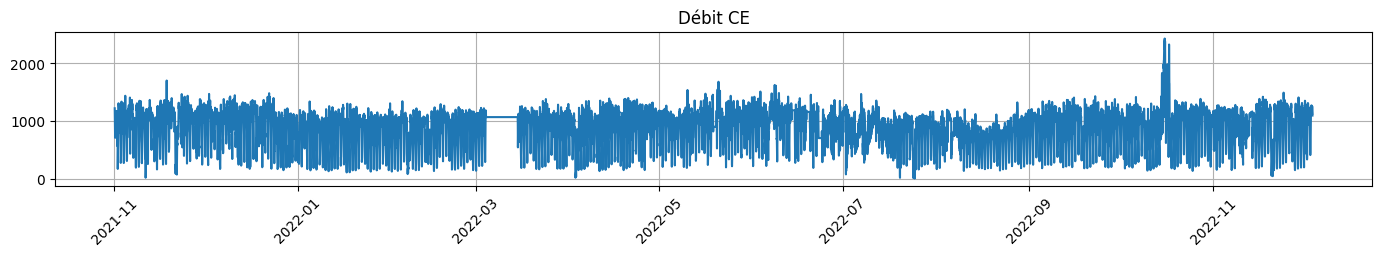

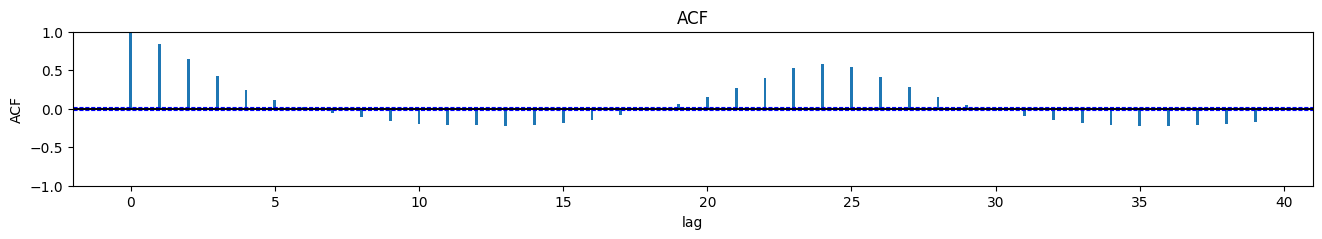

Text(0.5, 1.0, 'Lag Plot (7 jours)')

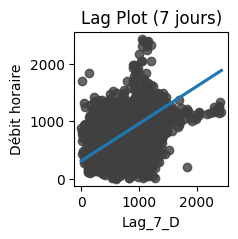

In [31]:
plot_series(ce_df["Débit horaire"], "Débit CE")

# ACF
y = np.log(ce_df["Débit horaire"])
y_len = len(y) # variable nécessaire pour l'utilisation de plot_sortie_acf
plot_sortie_acf(acf(np.asarray(y)), y_len)

# Lag plot
fig, ax = plt.subplots()
fig.set_size_inches(2, 2)
ax = sns.regplot(x=lag_feat_deb, y="Débit horaire", data=ce_deb, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot (7 jours)')

### Baseline results

In [32]:
lr_results = pd.DataFrame(columns=["Street", "Variable", "RMSE"], index = range(1, 7))

def evaluate(X, y):
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)
    RMSE = round(rmse(X_test, y_test), 1)
    return RMSE

In [33]:
variable = "Débit horaire"
rue = "Champs Elysées"
X = ce_deb[lag_feat_deb]
y = ce_deb[variable]
RMSE = evaluate(X, y)
lr_results.loc[1] = {
    "Street": rue,
    "Variable": variable,
    "RMSE":RMSE,
}

rue = "Saint Pères"
X = peres_deb[lag_feat_deb]
y = peres_deb[variable]
RMSE = evaluate(X, y)
lr_results.loc[2] = {
    "Street": rue,
    "Variable": variable,
    "RMSE":RMSE,
}

rue = "Convention"
X = convention_deb[lag_feat_deb]
y = convention_deb[variable]
RMSE = evaluate(X, y)
lr_results.loc[3] = {
    "Street": rue,
    "Variable": variable,
    "RMSE":RMSE,
}


variable = "Taux d'occupation"
rue = "Champs Elysées"
X = ce_taux[lag_feat_taux]
y = ce_taux[variable]
RMSE = evaluate(X, y)
lr_results.loc[4] = {
    "Street": rue,
    "Variable": variable,
    "RMSE":RMSE,
}

rue = "Saint Pères"
X = peres_taux[lag_feat_taux]
y = peres_taux[variable]
RMSE = evaluate(X, y)
lr_results.loc[5] = {
    "Street": rue,
    "Variable": variable,
    "RMSE":RMSE,
}

rue = "Convention"
X = convention_taux[lag_feat_taux]
y = convention_taux[variable]
RMSE = evaluate(X, y)
lr_results.loc[6] = {
    "Street": rue,
    "Variable": variable,
    "RMSE":RMSE,
}

In [34]:
lr_results

,Street,Variable,RMSE
1,Champs Elysées,Débit horaire,306.1
2,Saint Pères,Débit horaire,98.9
3,Convention,Débit horaire,271.6
4,Champs Elysées,Taux d'occupation,10.9
5,Saint Pères,Taux d'occupation,2.4
6,Convention,Taux d'occupation,7.5
